***Participantes (RM - NOME):***<br>
339624 - Camila<br>
339656 - Cleiton<br>
340214 - Henrique<br>
339708 - Roberto<br>
340192 - Sergio<br>

## **Criar um classificador de sentimento aplicando técnicas de PLN**
---

Utilizando o dataset de revisões de filmes em português [1], criar um classificador de sentimentos que consiga um score na métrica F1 Score superior a 70%.

Devem utilizar uma amostra de 20% e randon_state igual a 42 para testar as implementações e mensurar a métrica F1 Score (usar o parâmetro average = 'weighted') o restante dos dados devem ser utilizados para o treinamento (80%).

Fique a vontade para testar os métodos de pré-processamento, abordagens, algoritmos e bibliotecas, mas explique e justifique suas decisões.
O trabalho poderá ser feito em grupo de até 4 pessoas (mesmo grupo do Startup One).

Separe a implementação do seu modelo campeão junto com a parte de validação/teste de forma que o professor consiga executar todo o pipeline do modelo campeão.

Composição da nota:
- 50% - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, etc.)
- 50% - Baseado na performance obtida com o dataset de teste (conforme recomendação da amostra) no seu modelo campeão e na validação que o professor processar (Métrica F1 Score).

[1] - https://dados-ml-pln.s3-sa-east-1.amazonaws.com/reviews-pt-br.csv

# Bibliotecas utilizadas

In [76]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import wordcloud as wd
import re
from collections import Counter

import spacy

import nltk
from nltk.stem.rslp import RSLPStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
sb.set_theme(context='notebook', style='whitegrid')

nlp = spacy.load('pt_core_news_sm')
rslp = RSLPStemmer()

# Funções externas

In [217]:
# função de lematização completa do documento
def stemmer_text(frase):
  tokens = [rslp.stem(w) for w in frase.split()]
  return " ".join(tokens)

# função de lematização completa do documento
def lemmatizer_text(frase):
  doc = nlp(frase)
  tokens = [w.lemma_ for w in doc]
  return " ".join(tokens)

# função de lematização para os verbos do documento
def lemmatizer_verbs(frase):
  doc = nlp(frase)
  tokens = [w.lemma_ if w.pos_ == 'VERB' else w.text for w in doc]
  return " ".join(tokens)

def plural_singular(palavra):
  r2 = r"ses$|zes$|res$"
  r3 = r"ões$|ães$"
  r4 = r"ais$|éis$|óis$|uis$"
  r5 = r"is$"
  r6 = r"eis$"
  if palavra.endswith('s'):
    if re.findall(r2, palavra):
      return palavra[:-2]
    if re.findall(r3, palavra):
      return palavra[:-3] + "ão"
    if re.findall(r4, palavra):
      return palavra[:-2] + "l"
    if re.findall(r5, palavra):
      return palavra[:-1] + "l"
    if re.findall(r6, palavra):
      return palavra[:-1] + "il"
    if palavra.endswith('ns'):
      return palavra[:-2] + "m"
    return palavra[:-1]
  return palavra  

def pre(frase):
  regex = r"[`,.?:;!&\"]"
  palavras = frase.split()
  palavras = [p.lower() for p in palavras if p not in stops]
  palavras = [re.sub(regex, "", p) for p in palavras]
  palavras = [p for p in palavras if len(p) >= 3]
  palavras = [p for p in palavras if not p.isnumeric()]
  palavras = [plural_singular(p) for p in palavras]

  return " ".join(palavras)

In [213]:
t = "quantas vezes vamos ter de esperar para poder saber o que é amar ricardo"

d = nlp(t)
for w in d:
    print(w.text, w.pos_, w.lemma_, w.dep_)

quantas DET quanto amod
vezes NOUN vezar ROOT
vamos AUX ir dep
ter VERB ter ROOT
de SCONJ de mark
esperar VERB esperar xcomp
para SCONJ parir mark
poder VERB poder advcl
saber VERB saber xcomp
o PRON o det
que PRON que ccomp
é AUX ser cop
amar ADJ amar ccomp
ricardo NOUN ricardo ROOT


# Carregando os Dados

In [5]:
df = pd.read_csv('./data/reviews-pt-br.csv', encoding='utf-8')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44514 entries, 0 to 44513
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   codigo      44514 non-null  int64 
 1   texto       44514 non-null  object
 2   sentimento  44514 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [7]:
df.head(10)

,codigo,texto,sentimento
0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg
1,2,O Bravo parece indicar que o personagem princi...,neg
2,3,"Durante a Guerra pela Independência do Sul, GE...",pos
3,4,É fora de questão que a verdadeira Anna Anders...,pos
4,5,Concordo totalmente com outro dos revisores aq...,neg
5,6,Obra-prima absoluta de um filme! Boa noite Mr....,pos
6,7,Embora a palavra megalmania seja muito usada p...,pos
7,8,Esta tem que ser a peça mais incrível de porca...,neg
8,9,Eu suponho que todas as piadas internas são o ...,neg
9,10,"Se há um tema deste filme, é que as pessoas po...",pos


## Conferindo se temos dados nulos ou duplicados

In [8]:
df.isna().sum()

codigo        0
texto         0
sentimento    0
dtype: int64

In [9]:
df[df.duplicated()].count()

codigo        0
texto         0
sentimento    0
dtype: int64

## Distribuição das respostas

In [10]:
df.groupby('sentimento').count()

,codigo,texto
sentimento,,
neg,22307,22307
pos,22207,22207


In [11]:
# em percentual
round(df.groupby('sentimento').count().texto / df.shape[0] * 100, 2)

sentimento
neg    50.11
pos    49.89
Name: texto, dtype: float64

<AxesSubplot:xlabel='sentimento', ylabel='count'>

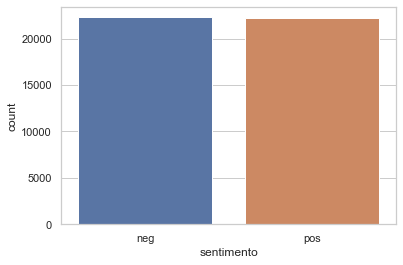

In [12]:
sb.countplot(x=df.sentimento)

## Criando o conjunto de stopwords (NLTK + SPACY)

In [57]:
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
stopwords_spacy = nlp.Defaults.stop_words
stops = list(set(stopwords_spacy).union(stopwords_nltk))
print(sorted(stopwords))

['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'diante', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dão', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'en

# Analisando o conjunto total das palavras

In [198]:
# exemplo de críticas no nosso dataframe
print(df.texto[0])
print()
print(df.texto[1536])
print()
print(df.texto[8192])

Esse bocejo de pia de cozinha de orçamento muito baixo é o tipo de filme que só pode ser feito no Reino Unido porque, em qualquer outro lugar do mundo, o mercado precisaria existir antes que fosse dada uma luz verde. Provavelmente auto-financiado, esta é claramente uma tentativa de corrigir questões importantes, mas enfraquece seu ponto de vista em que a questão precisa ser colocada, quem colocaria dinheiro para distribuir isso e, em segundo lugar, se uma audiência de mercado não existe para assistir, comprar ou alugar este filme, por que alguém se incomodaria em primeiro lugar? Minhas opiniões podem soar injustamente severas para um diretor de primeira viagem, mas esse é o tipo de filme que só vai minar a viabilidade comercial e os padrões de qualidade que apenas mantiveram uma indústria cinematográfica britânica. Avaliado em Edimburgo. 2 de 10.

Ambientada em Paris no ano de 1910, uma antiga e rica cantora de ópera decide entregar sua fortuna a sua linda gata Duquesa dublada por Eva 

In [58]:
# criando um texto completo com todas as críticas
texto_completo = " ".join([texto for texto in df.texto])

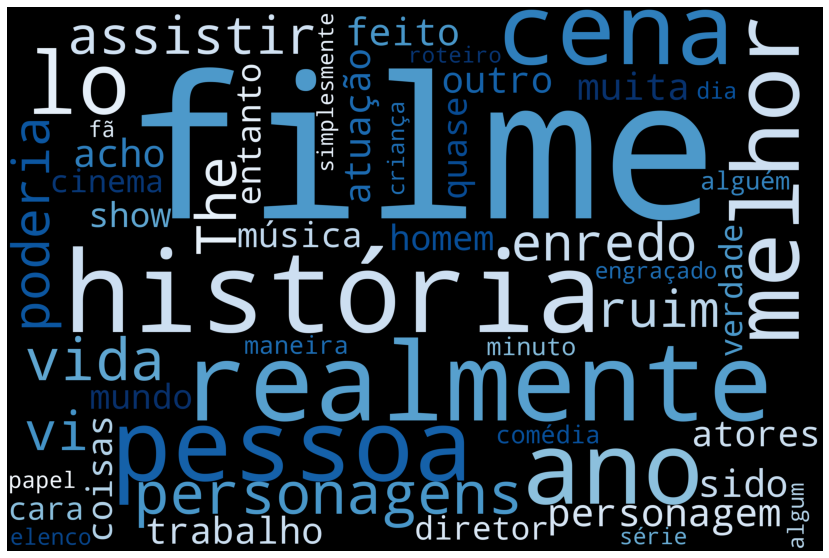

In [199]:
# criando uma wordcloud de todas as palavra sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

In [187]:
palavras = texto_completo.split()
len(palavras)

9843831

In [188]:
# retirando as stopwords das palavras
palavras = [p.lower() for p in palavras if p not in stops]
len(palavras)

5057320

In [189]:
# retirando pontuações das palavras
regex = r"[`,.?:;!&\"]"
palavras = [re.sub(regex, "", p) for p in palavras]
len(palavras)

5057320

In [190]:
#retirando palavras menores que 3 caracteres
palavras = [p for p in palavras if len(p) >= 3]
len(palavras)

4381077

In [191]:
# retirando os números das palavras
palavras = [p for p in palavras if not p.isnumeric()]
len(palavras)

4369278

In [192]:
#convertendo as palavras para o singular
palavras = [plural_singular(p) for p in palavras]
len(palavras)

4369278

In [194]:
c = Counter()
c.update(palavras)
c.most_common(50)

[('filme', 167259),
 ('história', 23782),
 ('personagem', 22551),
 ('realmente', 22428),
 ('melhor', 20618),
 ('isso', 19051),
 ('pessoa', 18864),
 ('cena', 18497),
 ('este', 17867),
 ('ano', 16701),
 ('vida', 12970),
 ('ruim', 12366),
 ('ator', 11888),
 ('assistir', 10334),
 ('homem', 10188),
 ('poderia', 10114),
 ('enredo', 10079),
 ('outro', 10040),
 ('coisa', 9908),
 ('acho', 9442),
 ('feito', 9097),
 ('sido', 9034),
 ('atuação', 8933),
 ('muita', 8850),
 ('diretor', 8624),
 ('trabalho', 8588),
 ('você', 8022),
 ('tempo', 7933),
 ('algum', 7620),
 ('música', 7471),
 ('show', 7402),
 ('mulher', 7387),
 ('quase', 7379),
 ('mundo', 7287),
 ('entanto', 7211),
 ('ele', 7071),
 ('pior', 6919),
 ('cara', 6885),
 ('verdade', 6875),
 ('então', 6780),
 ('real', 6747),
 ('alguém', 6708),
 ('cinema', 6666),
 ('como', 6600),
 ('maneira', 6475),
 ('minuto', 6432),
 ('comédia', 6411),
 ('disso', 6347),
 ('engraçado', 6297),
 ('ação', 6267)]

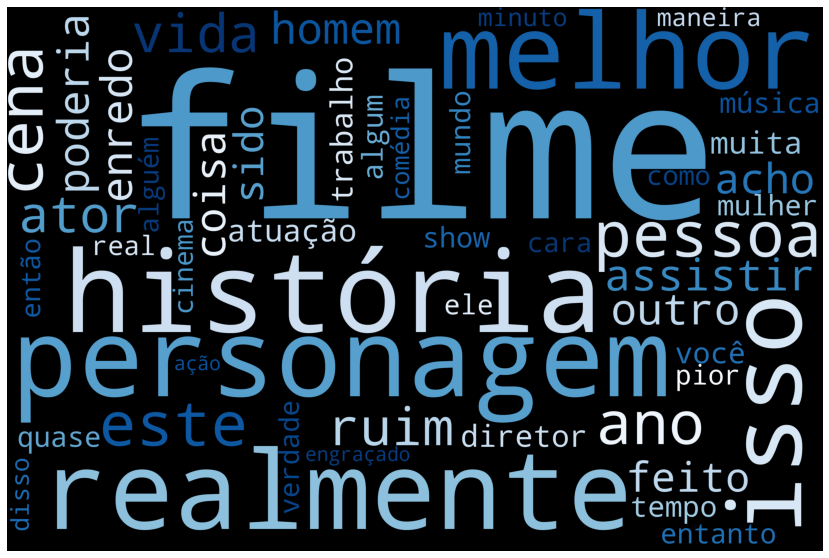

In [200]:
# criando uma wordcloud das palavras filtradas
#wordcloud = wd.WordCloud(width = 3000, height = 2000, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo)
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False).fit_words(dict(c))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

## Criando as colunas tratadas

In [43]:
%%time
df['stem'] = df.texto.apply(stemmer_text)

In [46]:
%time
df['lemm'] = df.texto.apply(lemmatizer_text)

In [60]:
%%time
df['verb'] = df.texto.apply(lemmatizer_verbs)

Wall time: 18min 57s


In [218]:
%%time
df['pre'] = df.texto.apply(pre)

Wall time: 59.7 s


In [219]:
df.to_csv("./data/criticas.csv")

In [220]:
df.head(10)

,codigo,texto,sentimento,pre
0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg,esse bocejo cozinha orçamento filme feito rein...
1,2,O Bravo parece indicar que o personagem princi...,neg,bravo indicar personagem principal claro coraj...
2,3,"Durante a Guerra pela Independência do Sul, GE...",pos,durante guerra independência general spanky mo...
3,4,É fora de questão que a verdadeira Anna Anders...,pos,verdadeira anna anderson princesa anastasia al...
4,5,Concordo totalmente com outro dos revisores aq...,neg,concordo totalmente outro revisor ficou satisf...
5,6,Obra-prima absoluta de um filme! Boa noite Mr....,pos,obra-prima absoluta filme noite mrtom rapidame...
6,7,Embora a palavra megalmania seja muito usada p...,pos,embora palavra megalmania usada descrever gene...
7,8,Esta tem que ser a peça mais incrível de porca...,neg,esta peça incrível porcaria cinematográfica as...
8,9,Eu suponho que todas as piadas internas são o ...,neg,suponho piada interna munchie clássico cult pe...
9,10,"Se há um tema deste filme, é que as pessoas po...",pos,tema filme pessoa lidar dificuldade imaginação...


## Dividindo a base em treino e teste

In [221]:
# dividindo com 20% para o treino e random state = 42
df_treino, df_teste = train_test_split(
      df, 
      test_size = 0.2, 
      random_state = 42
  )

In [222]:
# distribuição das respostas do treino em %
round(df_treino.groupby('sentimento').count() / df.shape[0] * 100, 2).texto

sentimento
neg    40.07
pos    39.93
Name: texto, dtype: float64

In [223]:
# distribuição das respostas do teste em %
round(df_teste.groupby('sentimento').count() / df.shape[0] * 100, 2).texto

sentimento
neg    10.04
pos     9.96
Name: texto, dtype: float64

## Criando o primeiro modelo de árvore de decisão

In [68]:
%%time
# vetorização em unigramas
vect = CountVectorizer(ngram_range=(1,1)) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7139
F1 Score: 0.7139
Wall time: 1min 25s


In [69]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")


Acuracidade: 0.7266
F1 Score: 0.7266
Wall time: 1min 9s


In [225]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.pre)
vect_treino = vect.transform(df_treino.pre)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.pre)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
#f1score = f1_score(teste, predito, average='weighted')

print(accuracy)
#print(f1score)

0.7245872177917556
Wall time: 1min


In [54]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.stem)
vect_treino = vect.transform(df_treino.stem)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.stem)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(teste, predito, average='weighted')

print(accuracy)
print(f1score)

0.6999887678310682
0.6999775483023176
Wall time: 1min 10s


In [59]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.lemm)
vect_treino = vect.transform(df_treino.lemm)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.lemm)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(teste, predito, average='weighted')

print(accuracy)
print(f1score)

0.7168370212287993
0.7168379214900593
Wall time: 1min 1s


In [65]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.verb)
vect_treino = vect.transform(df_treino.verb)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.verb)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(teste, predito, average='weighted')

print(accuracy)
print(f1score)

0.719982028529709
0.7199817529750344
Wall time: 1min 6s


In [57]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stopwords) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = RandomForestClassifier(random_state=42, n_jobs=-1)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(teste, predito, average='weighted')

print(accuracy)
print(f1score)


0.8539818038863305
0.8539673442180815
Wall time: 37.4 s


#### **Validação do professor**

Consolidar apenas os scripts do seu **modelo campeão**, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.